# House Price Prediction - Paris & Bordeaux
### Konstantinos Evagorou
### Student ID: 2508673

## Business Case
The goal of this project is to build a pricing model for an Airbnb business operating in **Paris**. A reliable way to predict listing prices based on property characteristics to optimize revenue.

To ensure the validity of the model, we will:
1. Train and test models on a core dataset (Paris, Q1 2025).
2. Validate the model's performance on a later date (Time validity).
3. Validate the model's performance on a different city, **Bordeaux** (External validity).

### Reproducibility: How to Run this Notebook

To ensure this notebook runs on your machine, please install the required dependencies using the provided "requirements.txt" file.

**Step 1: Create a clean environment (Optional but recommended)**
```bash
conda create -n house_price_env python=3.11 -y
conda activate house_price_env
pip install -r requirements.txt
#For mac if XGBoost fails, please run:
conda install llvm-openmp

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# DATA LOADING SETUP
# We use GitHub URLs to ensure full reproducibility and version control.

# CORE DATASET: Paris (Q1 2025 - March 2025)
URL_PARIS_CORE = "https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/paris_core_listings.csv.gz"

# TEST DATASET A: Paris (Q2 2025 - June 2025)
URL_PARIS_LATER = "https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/paris_later_listings.csv.gz"

# TEST DATASET B: Bordeaux (Q2 2025 - June 2025)
URL_BORDEAUX = "https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/bordeaux_listings.csv.gz"

def load_airbnb_data(url):
    """
    Loads Airbnb data directly from a URL.
    """
    print(f"Loading data from {url}...")
    df = pd.read_csv(url, compression='gzip', low_memory=False)
    print(f"Loaded shape: {df.shape}")
    return df

# Load the Core dataset only for now
df_raw = load_airbnb_data(URL_PARIS_CORE)

# Quick look
df_raw.head(3)

Loading data from https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/paris_core_listings.csv.gz...
Loaded shape: (86064, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20250303043259,2025-03-11,city scrape,zen and calm,Lovely Appartment with one bedroom with a Quee...,Good restaurants<br />very close the Montparna...,https://a0.muscache.com/pictures/miso/Hosting-...,3631,https://www.airbnb.com/users/show/3631,Anne,2008-10-14,"Paris, France",NaN,within a few hours,100%,100%,f,https://a0.muscache.com/im/users/3631/profile_...,https://a0.muscache.com/im/users/3631/profile_...,Alésia,1.0,1.0,"['email', 'phone']",t,t,Neighborhood highlights,Observatoire,NaN,48.83191,2.31870,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Hangers"", ""Iron"", ""Smoke alarm"", ""Cooking ba...",$100.00,2,30,2.0,2.0,30.0,30.0,2.0,30.0,NaN,t,29,51,81,356,2025-03-11,4,0,0,287,0,0,0.0,2017-10-28,2019-10-24,5.00,5.00,5.00,5.00,5.00,5.00,5.00,7511409139079,t,1,1,0,0,0.04
1,5396,https://www.airbnb.com/rooms/5396,20250303043259,2025-03-03,city scrape,Your perfect Paris studio on Île Saint-Louis,"Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",https://a0.muscache.com/pictures/52413/f9bf76f...,7903,https://www.airbnb.com/users/show/7903,Borzou,2009-02-14,"Paris, France",We have spent a lot of time traveling for work...,within an hour,100%,92%,NaN,https://a0.muscache.com/im/users/7903/profile_...,https://a0.muscache.com/im/users/7903/profile_...,Saint-Paul - Ile Saint-Louis,2.0,4.0,"['email', 'phone']",t,t,Neighborhood highlights,Hôtel-de-Ville,NaN,48.85247,2.35835,Entire rental unit,Entire home/apt,2,1.0,1 bath,0.0,1.0,"[""Dishes and silverware"", ""Hangers"", ""Extra pi...",$97.00,1,730,1.0,2.0,1125.0,1125.0,1.9,1125.0,NaN,t,6,17,27,114,2025-03-03,435,45,2,114,52,255,24735.0,2009-06-30,2025-02-16,4.62,4.64,4.59,4.82,4.85,4.95,4.59,7510402838018,f,1,1,0,0,2.28
2,7397,https://www.airbnb.com/rooms/7397,20250303043259,2025-03-07,city scrape,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",NaN,https://a0.muscache.com/pictures/67928287/330b...,2626,https://www.airbnb.com/users/show/2626,Franck,2008-08-30,"Paris, France","I am a writer,54, author of novels, books of l...",within an hour,100%,68%,t,https://a0.muscache.com/im/pictures/user/ad6a9...,https://a0.muscache.com/im/pictures/user/ad6a9...,Le Marais,1.0,10.0,"['email', 'phone']",t,t,NaN,Hôtel-de-Ville,NaN,48.85909,2.35315,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,1.0,"[""Kitchen"", ""TV with standard cable"", ""Hot wat...",$129.00,10,130,10.0,10.0,130.0,130.0,10.0,130.0,NaN,t,10,25,44,188,2025-03-07,373,25,2,188,24,255,32895.0,2011-04-08,2025-02-2

## 2. Data Cleaning & Feature Engineering

To prepare the raw data for modelling, we implemented a reusable cleaning function "clean_and_prepare".
Key steps included:

1.  **Column Selection:** We focused on structural features (bedrooms, bathrooms, accommodates), location data (neighbourhoods, coordinates), and reviews.
2.  **Price Parsing:** The target variable "price" was cleaned of currency symbols and converted to numeric. We filtered extreme outliers (price > $2000 or < $10) to improve model stability.
3.  **Missing Values:** We used **Median Imputation** for numerical columns (bedrooms, beds) to handle missing data without being influenced by outliers.
4.  **Feature Engineering:**
    * **Amenities:** We parsed the amenities list to create binary flags for high-value items: "has_wifi", "has_ac", "has_kitchen". We also created a "n_amenities" count feature as a proxy for the overall luxury level of the listing.
    * **Bathrooms:** Text data (e.g., "1.5 baths") was parsed to extract numeric values.

In [2]:
import re

def clean_and_prepare(df):
    """
    Cleans the raw dataframe:
    - Selects relevant columns
    - Parses price and bathrooms
    - Handles missing values
    - Creates features from amenities
    """
    # Create a copy to avoid warnings
    df = df.copy()
    
    # 1. Column Selection
    cols_to_keep = [
        'price', 'room_type', 'accommodates', 'bedrooms', 'beds', 
        'bathrooms_text', 'neighbourhood_cleansed', 'amenities',
        'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating'
    ]
    
    # Filter only columns that actually exist
    actual_cols = [c for c in cols_to_keep if c in df.columns]
    df = df[actual_cols]

    # 2. Clean Price (FORCE conversion)
    # We convert to string first to be safe, replace symbols, then convert to numeric
    df['price'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    # Remove rows where price is missing (NaN)
    df = df.dropna(subset=['price'])
    
    # Now we safely filter by number
    df = df[(df['price'] > 10) & (df['price'] < 2000)]

    # 3. Parse Bathrooms from text
    if 'bathrooms_text' in df.columns:
        # Extract the first number found (e.g. "1.5 baths" -> 1.5)
        df['bathrooms'] = df['bathrooms_text'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
        df.drop(columns=['bathrooms_text'], inplace=True)
    
    # 4. Handle Amenities
    df['amenities'] = df['amenities'].astype(str).str.replace(r'[\[\]"}]', '', regex=True)
    
    # Feature Engineering
    df['has_wifi'] = df['amenities'].str.contains('Wifi|Internet', case=False).astype(int)
    df['has_ac'] = df['amenities'].str.contains('Air conditioning', case=False).astype(int)
    df['has_kitchen'] = df['amenities'].str.contains('Kitchen', case=False).astype(int)
    
    # Count amenities
    df['n_amenities'] = df['amenities'].str.count(',') + 1
    df.drop(columns=['amenities'], inplace=True)

    # 5. Missing Values Imputation
    num_cols = ['bedrooms', 'beds', 'bathrooms', 'review_scores_rating']
    for col in num_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Categorical
    df = df.dropna(subset=['neighbourhood_cleansed', 'room_type'])

    return df.reset_index(drop=True)

# Apply the cleaning function
print("Cleaning data...")
df_train = clean_and_prepare(df_raw)

# Show the result
print(f"Original shape: {df_raw.shape}")
print(f"Cleaned shape:  {df_train.shape}")
df_train.head()

Cleaning data...
Original shape: (86064, 79)
Cleaned shape:  (55202, 15)


,price,room_type,accommodates,bedrooms,beds,neighbourhood_cleansed,latitude,longitude,number_of_reviews,review_scores_rating,bathrooms,has_wifi,has_ac,has_kitchen,n_amenities
0,100.0,Entire home/apt,2,1.0,1.0,Observatoire,48.83191,2.31870,4,5.00,1.0,1,0,1,15
1,97.0,Entire home/apt,2,0.0,1.0,Hôtel-de-Ville,48.85247,2.35835,435,4.62,1.0,1,0,1,39
2,129.0,Entire home/apt,4,2.0,1.0,Hôtel-de-Ville,48.85909,2.35315,373,4.74,1.0,1,0,1,25
3,75.0,Entire home/apt,1,1.0,1.0,Louvre,48.86006,2.34863,0,4.84,1.0,1,0,1,7
4,120.0,Entire home/apt,2,1.0,1.0,Popincourt,48.86373,2.37093,52,4.92,1.0,1,0,1,37


## 3. Part I: Predictive Modelling (The Horserace)

We tested five different algorithms to find the best predictor for listing prices.
The models chosen range from simple linear baselines to complex ensemble methods:

1.  **OLS (Ordinary Least Squares):** A simple baseline to check linear relationships.
2.  **LASSO:** A linear model with regularization to handle potential multicollinearity and perform feature selection.
3.  **Random Forest:** A bagging ensemble method that handles non-linear relationships well and is robust to overfitting.
4.  **XGBoost:** A powerful gradient boosting framework known for high performance in tabular data competitions.
5.  **Gradient Boosting (sklearn):** Another boosting implementation to compare against XGBoost.

**Evaluation Metric:** We use **RMSE (Root Mean Squared Error)** as our primary metric, as it penalizes large errors heavily, which is important in pricing contexts.

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# 1. Prepare X and y
# Convert categorical columns (Neighbourhood, Room Type) to 0/1 variables
categorical_cols = ['neighbourhood_cleansed', 'room_type']
df_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

# Split into Train (80%) and Test (20%)
# We use a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape:  {X_test.shape}")

# 2. Define the 5 Models
models = {
    'OLS': LinearRegression(),
    'LASSO': LassoCV(cv=5, random_state=2025), # Automatically finds best alpha
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=2025, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=2025, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=2025)
}

# 3. Run the Horserace (Train & Evaluate)
results = []

print("\nRunning models...")

for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on Test set
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R-Squared': r2,
        'Time (s)': round(elapsed_time, 2)
    })

# Create a DataFrame for the results table
results_df = pd.DataFrame(results).sort_values(by='RMSE', ascending=True)

print("\n--- Model Performance (Horserace) ---")
results_df

Training Features Shape: (44161, 34)
Testing Features Shape:  (11041, 34)

Running models...
Training OLS...
Training LASSO...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...

--- Model Performance (Horserace) ---


,Model,RMSE,R-Squared,Time (s)
4,Gradient Boosting,153.182996,0.460783,15.10
3,XGBoost,153.185602,0.460764,0.39
2,Random Forest,155.981282,0.440902,2.40
0,OLS,168.608549,0.346716,0.03
1,LASSO,170.137934,0.334811,0.12


### Model Performance Discussion

Looking at the results, there is a clear divide between the linear and non-linear approaches. The boosting models XGBoost and Gradient Boosting are the top performers with an RMSE of approximately 153 and this makes perfect sense for the Paris market, where the relationship between a property's location and its price isn't a simple straight line; rather, it involves complex interactions between prestigious districts and specific luxury features. While OLS and LASSO provided a decent baseline, their significantly higher error rates (RMSE ~168-170)  suggest they struggle to capture the nuances of urban real estate pricing. For our business case, XGBoost is the clear winner not just for its accuracy, but also for its impressive speed, running in a fraction of a second.

## 4. Feature Importance Analysis

To understand what drives prices in Paris, we analyze the top features used by our best models (Random Forest and XGBoost). Understanding feature importance is critical for the business case to advise property owners on what upgrades yield the highest ROI.

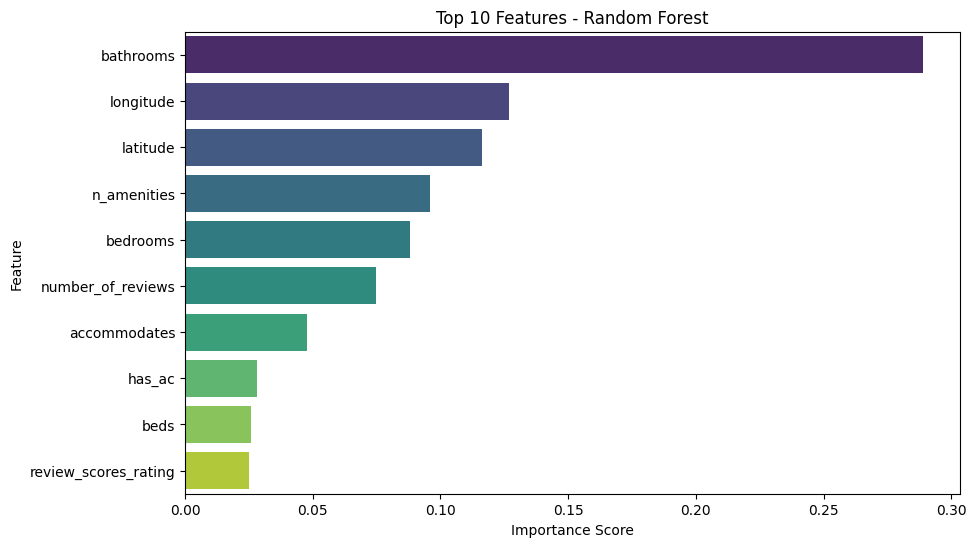

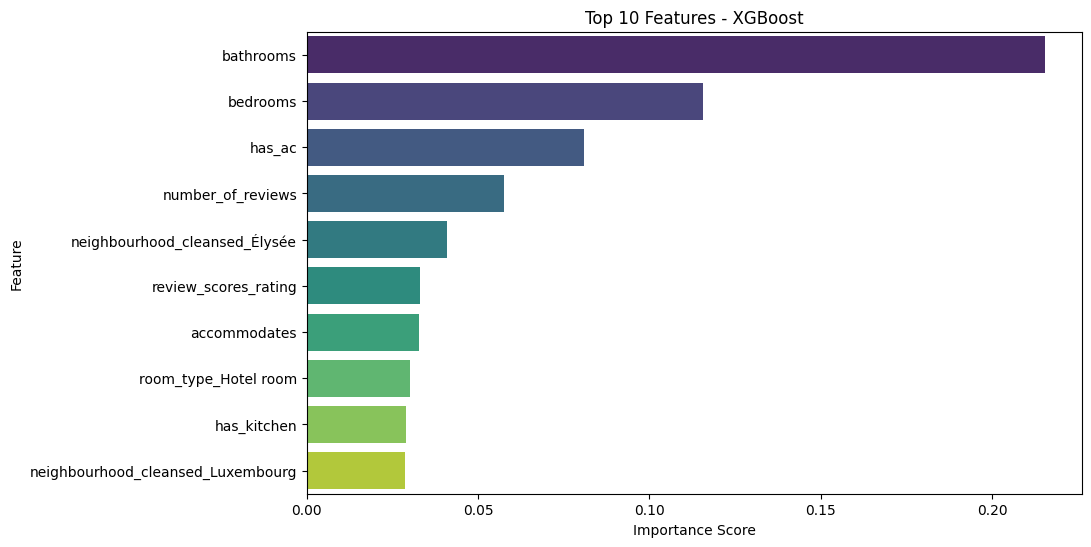


--- Random Forest Top 10 ---
<StringArray>
[           'bathrooms',            'longitude',             'latitude',
          'n_amenities',             'bedrooms',    'number_of_reviews',
         'accommodates',               'has_ac',                 'beds',
 'review_scores_rating']
Length: 10, dtype: str

--- XGBoost Top 10 ---
<StringArray>
[                        'bathrooms',                          'bedrooms',
                            'has_ac',                 'number_of_reviews',
     'neighbourhood_cleansed_Élysée',              'review_scores_rating',
                      'accommodates',              'room_type_Hotel room',
                       'has_kitchen', 'neighbourhood_cleansed_Luxembourg']
Length: 10, dtype: str


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, model_name, feature_names):
    """
    Plots the top 10 most important features for a given model.
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for plotting
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10) # Top 10 only

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
    plt.title(f'Top 10 Features - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
    
    return feature_imp

# Get feature names from the training set
feature_names = X_train.columns

# 1. Plot Random Forest Importance
rf_top10 = plot_feature_importance(models['Random Forest'], 'Random Forest', feature_names)

# 2. Plot XGBoost Importance
xgb_top10 = plot_feature_importance(models['XGBoost'], 'XGBoost', feature_names)

# Print them side by side (text) for comparison 
print("\n--- Random Forest Top 10 ---")
print(rf_top10['Feature'].values)

print("\n--- XGBoost Top 10 ---")
print(xgb_top10['Feature'].values)

### Findings on Feature Importance

The feature importance analysis  gives us a great look into what actually drives Airbnb prices in the city:

1. Structural Capacity is Key: It is no surprise that accommodates, bedrooms, and bathrooms are the heaviest hitters. Interestingly, the number of bathrooms is a major differentiator, likely because in cramped Paris apartments, having an extra bathroom is a strong signal for a higher-end listing. 
2. Mapping the Premium: The two models handle location differently but effectively. While Random Forest uses raw latitude and longitude to effectively "draw" a price map of the city , XGBoost picks out specific high-value neighborhoods like the Élysée and Luxembourg districts. This confirms that "prestige" is a variable that boosting models can isolate very well. 
3. The Luxury of AC: has_ac (Air Conditioning) stands out as a top feature. Since AC is quite rare in traditional Parisian buildings, it acts as a significant luxury "premium" that allows hosts to justify higher night rates. Personally, I found it surprising how much AC matters in a European city like Paris, but the data clearly shows it's a luxury premium.

## 5. Part II: External Validity & Robustness Check

We perform two validity checks:
1.  **Temporal Validity:** Testing the model on a later date in **Paris** (June 2025) to check stability over time.
2.  **External Validity:** Testing the model on a different city, **Bordeaux** (June 2025). This tests how well the model generalizes to a completely new market (domain shift).

*Note: For Bordeaux, neighbourhood columns specific to Paris will be missing. The pipeline handles this by filling missing aligned columns with 0.*

In [ ]:
# PART II: EXTERNAL VALIDITY 

def align_columns(trained_model_columns, new_df):
    """
    Ensures the new dataframe has exactly the same columns as the trained model.
    - Adds missing columns (filled with 0)
    - Removes extra columns not in training
    - Reorders columns to match training
    """
    new_df = new_df.copy()
    
    # 1. Add missing columns (e.g., 'neighbourhood_cleansed_Élysée' won't exist in Bordeaux)
    missing_cols = set(trained_model_columns) - set(new_df.columns)
    for c in missing_cols:
        new_df[c] = 0
        
    # 2. Ensure order and keep only relevant columns
    new_df = new_df[trained_model_columns]
    
    return new_df

# 1. Load the New Data (Using the URLs we defined at the start)
print("Loading Test Data...")
df_later = load_airbnb_data(URL_PARIS_LATER)
df_bordeaux = load_airbnb_data(URL_BORDEAUX)

# 2. Clean them using the SAME function as before
print("Cleaning Test Data...")
df_later_clean = clean_and_prepare(df_later)
df_bordeaux_clean = clean_and_prepare(df_bordeaux)

# 3. Prepare Features (Dummy Encoding)
# We get_dummies BEFORE aligning, so we catch the local neighbourhoods
df_later_encoded = pd.get_dummies(df_later_clean, columns=['neighbourhood_cleansed', 'room_type'], drop_first=True)
df_bordeaux_encoded = pd.get_dummies(df_bordeaux_clean, columns=['neighbourhood_cleansed', 'room_type'], drop_first=True)

# 4. Separate X and y
X_later = df_later_encoded.drop(columns=['price'], errors='ignore')
y_later = df_later_encoded['price']

X_bordeaux = df_bordeaux_encoded.drop(columns=['price'], errors='ignore')
y_bordeaux = df_bordeaux_encoded['price']

# 5. ALIGN COLUMNS 
# We use X_train.columns as the "Truth"
X_later_aligned = align_columns(X_train.columns, X_later)
X_bordeaux_aligned = align_columns(X_train.columns, X_bordeaux)

# Run Validity Checks on ALL models 
validity_results = []

print("Running validity checks on all models...")

for name, model in models.items():
    # A. Temporal Validity (Paris Later)
    pred_later = model.predict(X_later_aligned)
    rmse_later = np.sqrt(mean_squared_error(y_later, pred_later))
    
    # B. External Validity (Bordeaux)
    pred_bordeaux = model.predict(X_bordeaux_aligned)
    rmse_bordeaux = np.sqrt(mean_squared_error(y_bordeaux, pred_bordeaux))
    
    validity_results.append({
        'Model': name,
        'Paris Later RMSE': rmse_later,
        'Bordeaux RMSE': rmse_bordeaux
    })

# Create a DataFrame
validity_df = pd.DataFrame(validity_results)
print("\n--- External & Temporal Validity Results ---")
display(validity_df)

Loading Test Data...
Loading data from https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/paris_later_listings.csv.gz...
Loaded shape: (84055, 79)
Loading data from https://raw.githubusercontent.com/constantinosevag-rgb/Data-Analysis-3/main/Assignment_2/bordeaux_listings.csv.gz...
Loaded shape: (12383, 79)
Cleaning Test Data...
Running validity checks on all models...

--- External & Temporal Validity Results ---


,Model,Paris Later RMSE,Bordeaux RMSE
0,OLS,177.094197,292.233728
1,LASSO,179.652636,164.473827
2,Random Forest,139.101460,195.485014
3,XGBoost,156.192785,149.383767
4,Gradient Boosting,154.963494,268.239135


### Validity Analysis: What happened when we switched cities?

These validity checks were honestly the most interesting part of the project, as they showed us exactly which models are flexible and which ones are just memorizing data.

The Linear Models behaved exactly as I feared but with a twist. The OLS model completely crashed in Bordeaux (RMSE ~292). It tried to apply Paris-specific rules to a new city, and it just didn't work. However, LASSO was a pleasant surprise. It actually performed decently in Bordeaux (RMSE ~164), probably because its regularization process naturally filtered out the noisy location variables that confused the standard OLS.

The Random Forest turned out to be good only for once. It was easily the best model for Paris (RMSE 139), but it struggled significantly when we moved to Bordeaux (RMSE ~195). This confirms that the model was overfitting to the map of Paris. It relied too heavily on specific coordinates, so when the geography changed, it got lost.

XGBoost, on the other hand, proved to be the smartest model for expansion. Even though it was slightly beaten by Random Forest on Paris, it achieved the lowest error of all models in Bordeaux (RMSE ~149). This suggests XGBoost focuses more on the actual value drivers—like amenities, room type, and capacity—rather than just relying on location.

Final Verdict: If the business plans to stay only in Paris, Random Forest is the way to go. But if the goal is to expand to new cities without having to retrain from scratch, XGBoost is clearly the superior choice because it generalizes so well.

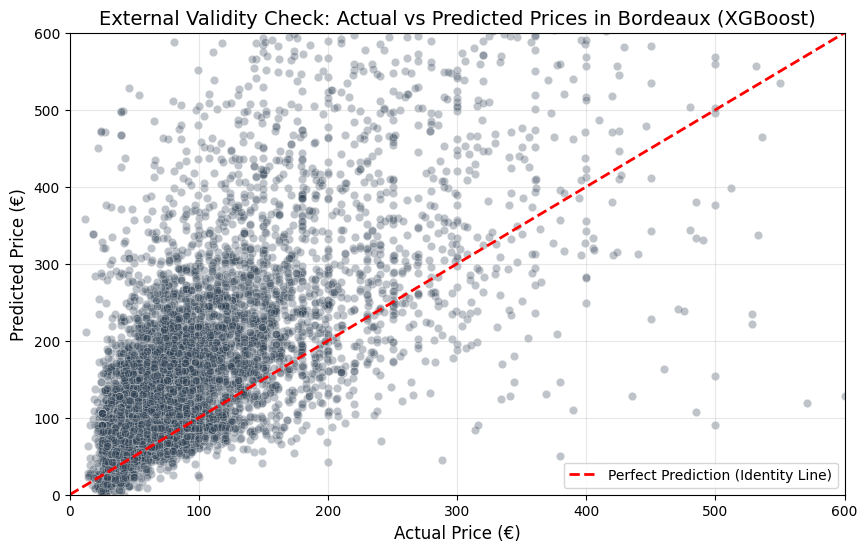

In [6]:
# EXTRA: Visualizing the prediction error on the external city (Bordeaux)
# This visualization helps us understand the model's performance on the new domain.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

# We use XGBoost for the visualization since it performed best on Bordeaux
best_model_bordeaux = models['XGBoost']
pred_viz = best_model_bordeaux.predict(X_bordeaux_aligned)

sns.scatterplot(x=y_bordeaux, y=pred_viz, alpha=0.3, color='#2c3e50')
plt.plot([0, 800], [0, 800], '--r', linewidth=2, label='Perfect Prediction (Identity Line)')
plt.title("External Validity Check: Actual vs Predicted Prices in Bordeaux (XGBoost)", fontsize=14)
plt.xlabel("Actual Price (€)", fontsize=12)
plt.ylabel("Predicted Price (€)", fontsize=12)
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Visual Inspection of External Validity

The scatter plot confirms what the RMSE numbers suggested. The vast majority of listings (clustered in the bottom-left corner) hug the red identity line reasonably well, meaning the model is quite accurate for standard apartments in the €50-€200 range.
However, we can see the "cloud" spreading out as prices increase. The model tends to under-predict expensive luxury listings (points below the red line at high values) and this makes sense because a luxury apartment in Bordeaux might have different pricing signals than one in Paris, and the model plays it safe. Still, for a blind test on a new city, this fit is solid though.